# Import Library

In [85]:
# Standard Libraries
import os
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# NLTK Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# WordCloud
from wordcloud import WordCloud

# Scikit-learn Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# Imbalanced Learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# LightGBM
from lightgbm import LGBMClassifier

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost

# Optuna for Hyperparameter Optimization
import optuna

# Preprocessing and EDA

## Data Collection

In [2]:
# Import Dataset
df = pd.read_csv('../dataset/YoutubeCommentsDataSet.csv')
df.head(5)

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


In [4]:
# Checking Missing Value from dataset
df.isnull().sum()

Comment      44
Sentiment     0
dtype: int64

In [5]:
# Show data with missing value
df[df.isnull().any(axis=1)]

,Comment,Sentiment
602,NaN,negative
716,NaN,neutral
812,NaN,positive
1021,NaN,positive
1023,NaN,neutral
1041,NaN,positive
1094,NaN,positive
2443,NaN,positive
3014,NaN,positive
3235,NaN,positive


In [6]:
# Show missing value in Sentiment Columns
df[df.isnull().any(axis=1)]['Sentiment'].value_counts()

Sentiment
positive    30
neutral     13
negative     1
Name: count, dtype: int64

In [7]:
# Drop data with missing value
df.dropna(inplace=True)

In [8]:
# Checking Duplicated Data
df.duplicated().sum()

490

In [9]:
# Show Duplicated Data
df[df.duplicated()]

,Comment,Sentiment
173,from all the stuff mentioned i have the dji mi...,positive
518,happy independence day to ukraine and glory t...,negative
847,linus just turn the key lights 180 and bounce ...,positive
848,dan continues to be my new favorite he has suc...,positive
849,dan managing to set up his soldering station o...,positive
...,...,...
18145,explore our free courses with completion certi...,neutral
18283,thanks for this video very neatly calmly expla...,positive
18298,explore our free courses with completion certi...,neutral
18308,do you want to learn technology from me check ...,neutral


In [10]:
# Drop Duplicated Data
df.drop_duplicates(inplace=True)

In [11]:
# Checking Comment with blank value
df[(df['Comment'].str.strip() == '')]

,Comment,Sentiment


In [12]:
# Change comment to be lowercase
df['Comment'] = df['Comment'].str.lower()

df.head(5)

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [13]:
# Checking if the comment starts or ends with a blank space
df[df['Comment'].apply(lambda x: x.endswith(' ') or x.startswith(' '))]

,Comment,Sentiment
20,linus just turn the key lights 180 and bounce ...,positive
30,unstoppable experiments with liquid nitrogen,positive
35,കേരളത്തിൽ ആദ്യമായി പെട്രോളിനെ എയ്സ് ആക്കിയ m4...,neutral
38,തന്നെ തളർത്താൻ നോക്കിയവർ പോലും അവന്റെ ഉയർച്ചയി...,neutral
39,എത്ര എടുത്താലും തീരാത്ത liquid nitrogen,neutral
...,...,...
18250,wow congratulations for starting such an amazi...,positive
18278,omg such awesome day to day life examples give...,positive
18343,amazing explanation i loved the way you taught,positive
18349,idk if you realise the intensity of positive i...,positive


In [14]:
# count the number of comments that start or end with a blank space
df['Comment'] = df['Comment'].str.strip()

df['Comment'].apply(lambda x: x.endswith(' ') or x.startswith(' ')).sum()

0

In [15]:
# Checking if the comment has a URL

url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

comment_url = df[df['Comment'].str.contains(url_pattern, '', regex=True)]

comment_url.head(5)

,Comment,Sentiment


In [16]:
# Checking if the comment has a Newline

comment_newline = df[df['Comment'].str.contains('\n')]

comment_newline.head(5)

,Comment,Sentiment


## EDA

<Axes: xlabel='Sentiment', ylabel='count'>

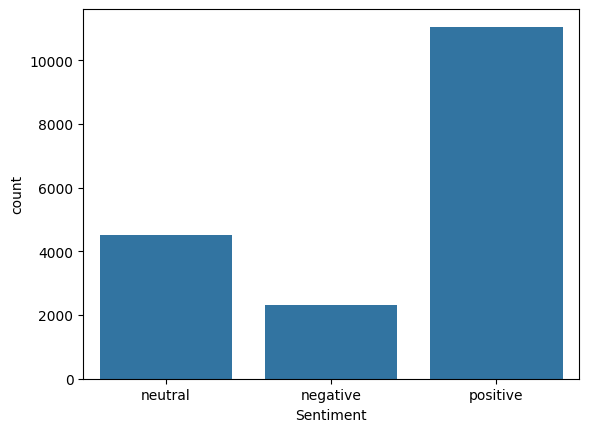

In [17]:
# Distribution Sentiment Value
sns.countplot(data=df, x='Sentiment')

In [18]:
# Show Percentage of total in the Sentiment Columns
df['Sentiment'].value_counts(normalize=True).mul(100).round(2)

Sentiment
positive    61.84
neutral     25.19
negative    12.96
Name: proportion, dtype: float64

In [19]:
# Add Column word_count
df['word_count'] = df['Comment'].apply(lambda x: len(x.split()))

df.head(5)

,Comment,Sentiment,word_count
0,lets not forget that apple pay in 2014 require...,neutral,57
1,here in nz 50 of retailers don’t even have con...,negative,29
2,i will forever acknowledge this channel with t...,positive,31
3,whenever i go to a place that doesn’t take app...,negative,83
4,apple pay is so convenient secure and easy to ...,positive,26


In [20]:
df['word_count'].describe()

count    17874.000000
mean        32.991664
std         45.526381
min          1.000000
25%         12.000000
50%         21.000000
75%         38.000000
max       1353.000000
Name: word_count, dtype: float64

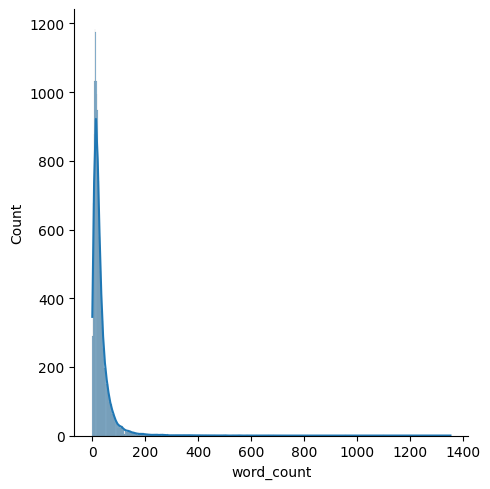

In [21]:
sns.displot(data=df, x='word_count', kde=True)

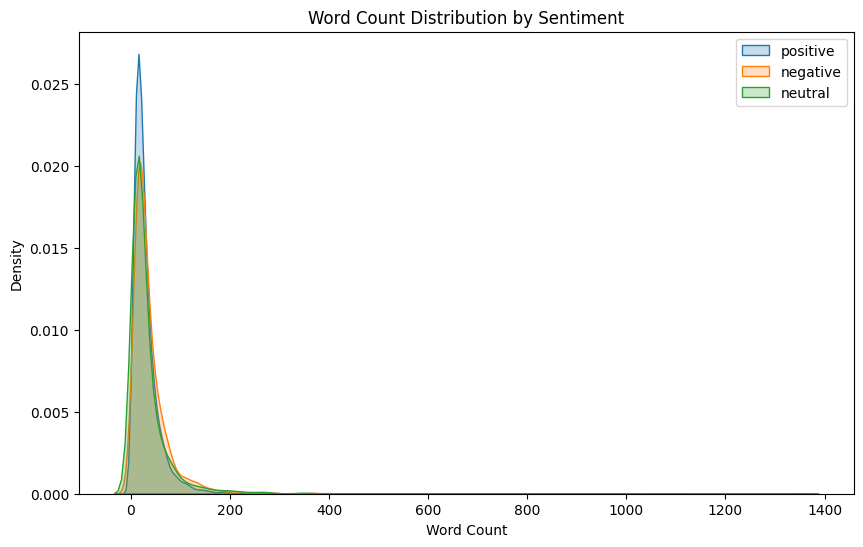

In [22]:
# Compare with Sentiment Value
plt.figure(figsize=(10, 6))

sns.kdeplot(df[df['Sentiment'] == 'positive']['word_count'], label='positive', fill=True)
sns.kdeplot(df[df['Sentiment'] == 'negative']['word_count'], label='negative', fill=True)
sns.kdeplot(df[df['Sentiment'] == 'neutral']['word_count'], label='neutral', fill=True)

plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()
plt.show()

<Axes: ylabel='word_count'>

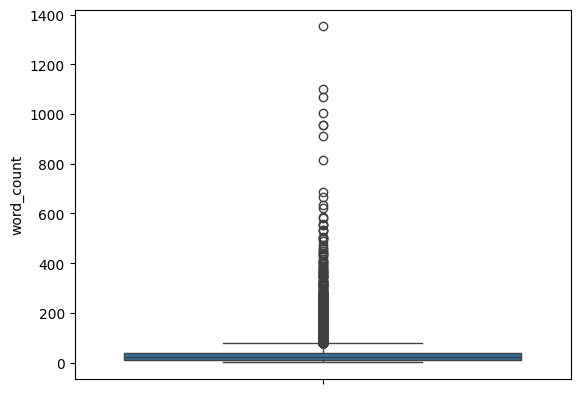

In [23]:
sns.boxplot(df['word_count'])

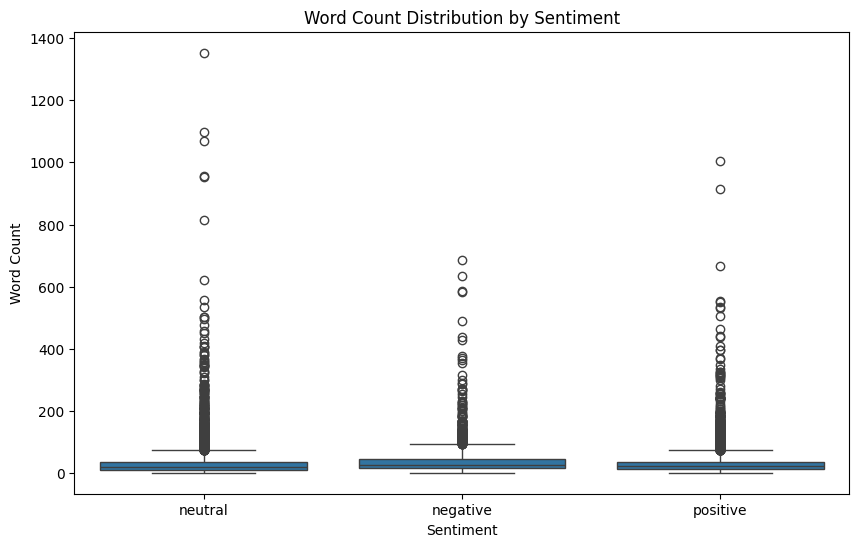

In [24]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x='Sentiment', y='word_count')
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.show()

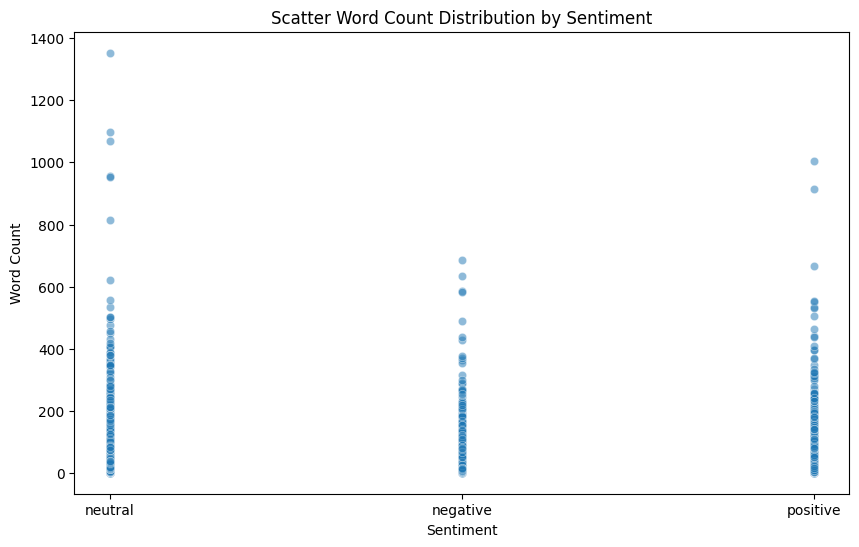

In [25]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df, x='Sentiment', y='word_count', alpha=0.5)

plt.title('Scatter Word Count Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.show()

<Axes: xlabel='Sentiment', ylabel='word_count'>

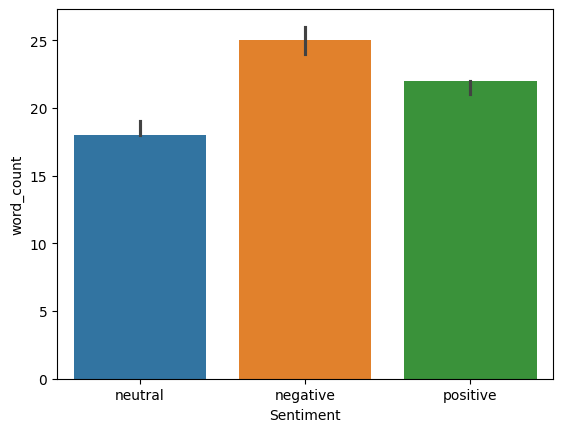

In [26]:
sns.barplot(df, x='Sentiment', y='word_count', hue='Sentiment', estimator='median')

In [27]:
# Add stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

df['num_stopwords'] = df['Comment'].apply(lambda x: sum(1 for word in x.split() if word in stop_words))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
df.head(5)

,Comment,Sentiment,word_count,num_stopwords
0,lets not forget that apple pay in 2014 require...,neutral,57,23
1,here in nz 50 of retailers don’t even have con...,negative,29,10
2,i will forever acknowledge this channel with t...,positive,31,16
3,whenever i go to a place that doesn’t take app...,negative,83,34
4,apple pay is so convenient secure and easy to ...,positive,26,12


C:\Users\Acer\AppData\Local\Temp\ipykernel_23512\328227682.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


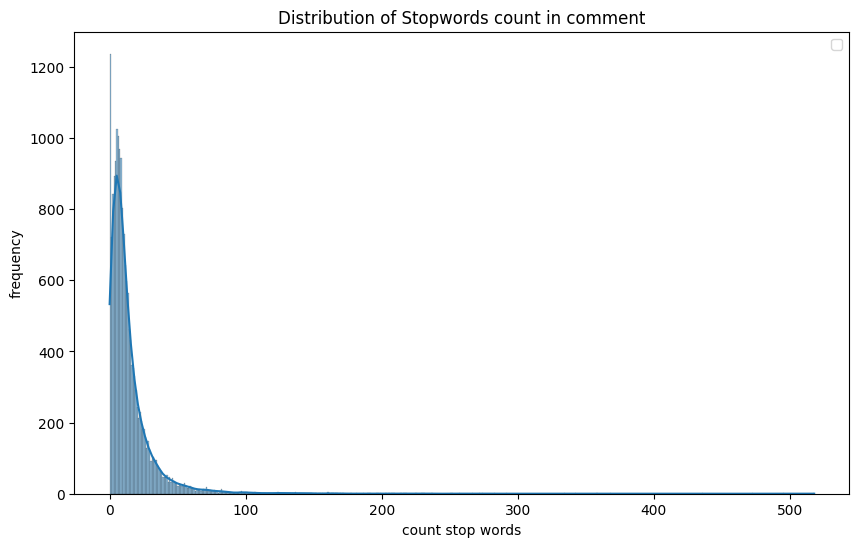

In [29]:
plt.figure(figsize=(10, 6))

sns.histplot(df['num_stopwords'], kde=True)

plt.title('Distribution of Stopwords count in comment')
plt.xlabel('count stop words')
plt.ylabel('frequency')
plt.legend()
plt.show()

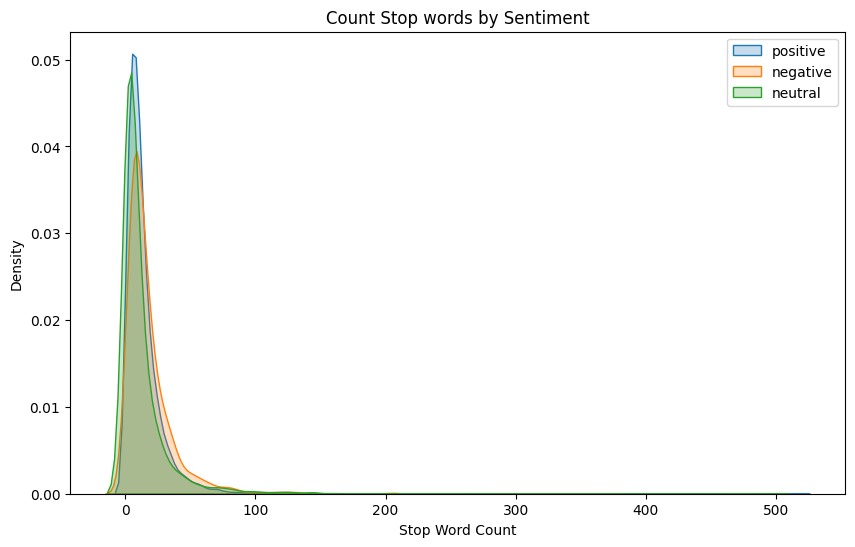

In [30]:
plt.figure(figsize=(10, 6))

sns.kdeplot(df[df['Sentiment'] == 'positive']['num_stopwords'], label='positive', fill=True)
sns.kdeplot(df[df['Sentiment'] == 'negative']['num_stopwords'], label='negative', fill=True)
sns.kdeplot(df[df['Sentiment'] == 'neutral']['num_stopwords'], label='neutral', fill=True)

plt.title('Count Stop words by Sentiment')
plt.xlabel('Stop Word Count')
plt.ylabel('Density')
plt.legend()
plt.show()

<Axes: xlabel='Sentiment', ylabel='num_stopwords'>

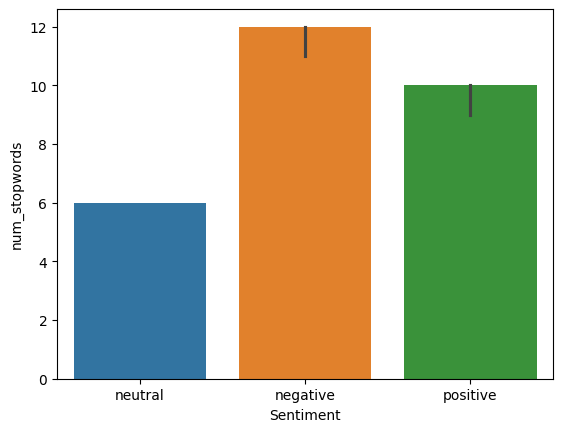

In [31]:
sns.barplot(df, x='Sentiment', y='num_stopwords', hue='Sentiment', estimator='median')

C:\Users\Acer\AppData\Local\Temp\ipykernel_23512\3862441610.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_df, x='Stopword', y='Count', palette='viridis')


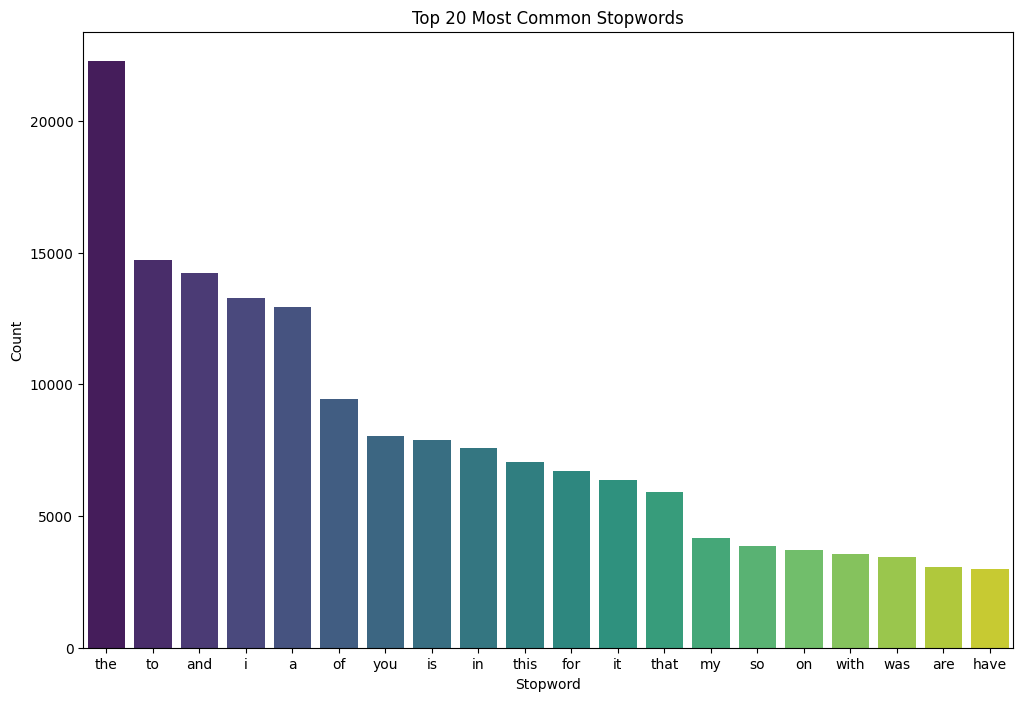

In [32]:
# Checking Top 20 Most Common Stopwords

all_stopwords = [word for comment in df['Comment'] for word in comment.split() if word in stop_words]

most_common_stopwords = Counter(all_stopwords).most_common(20)

top_20_df = pd.DataFrame(most_common_stopwords, columns=['Stopword', 'Count'])

plt.figure(figsize=(12, 8))

sns.barplot(data=top_20_df, x='Stopword', y='Count', palette='viridis')

plt.title('Top 20 Most Common Stopwords')
plt.xlabel('Stopword')
plt.ylabel('Count')
plt.show()

In [33]:
# Add num_char columns
df['num_char'] = df['Comment'].apply(len)

df.head(5)

,Comment,Sentiment,word_count,num_stopwords,num_char
0,lets not forget that apple pay in 2014 require...,neutral,57,23,317
1,here in nz 50 of retailers don’t even have con...,negative,29,10,163
2,i will forever acknowledge this channel with t...,positive,31,16,183
3,whenever i go to a place that doesn’t take app...,negative,83,34,450
4,apple pay is so convenient secure and easy to ...,positive,26,12,135


In [34]:
df['num_char'].describe()

count    17874.000000
mean       177.567976
std        252.165111
min          2.000000
25%         66.000000
50%        113.000000
75%        201.000000
max       7847.000000
Name: num_char, dtype: float64

In [35]:
#  calculate character frequency
all_text = ' '.join(df['Comment'])

char_frequency = Counter(all_text)

char_frequency_df = pd.DataFrame(char_frequency.most_common(20), columns=['Char', 'Count']).sort_values(by='Count', ascending=False)

char_frequency_df['Char'].values

array([' ', 'e', 't', 'a', 'o', 'i', 'n', 's', 'r', 'h', 'l', 'd', 'u',
       'c', 'm', 'y', 'g', 'p', 'w', 'f'], dtype=object)

In [36]:
char_frequency_df.head(50)

,Char,Count
0,,590996
1,e,301435
2,t,225325
3,a,207323
4,o,200811
5,i,192615
6,n,172531
7,s,168467
8,r,137793
9,h,120846


In [37]:
# Add num_punctuations column
df['num_punctuations'] = df['Comment'].apply(
    lambda x: sum([1 for char in x if char in '.,!?;:"\'()[]{}-'])
)

df.head(5)

,Comment,Sentiment,word_count,num_stopwords,num_char,num_punctuations
0,lets not forget that apple pay in 2014 require...,neutral,57,23,317,0
1,here in nz 50 of retailers don’t even have con...,negative,29,10,163,0
2,i will forever acknowledge this channel with t...,positive,31,16,183,0
3,whenever i go to a place that doesn’t take app...,negative,83,34,450,0
4,apple pay is so convenient secure and easy to ...,positive,26,12,135,0


In [38]:
df['num_punctuations'].describe()

count    17874.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: num_punctuations, dtype: float64

C:\Users\Acer\AppData\Local\Temp\ipykernel_23512\2500931515.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_bigrams_df, x='Count', y='Bigram', palette='viridis')


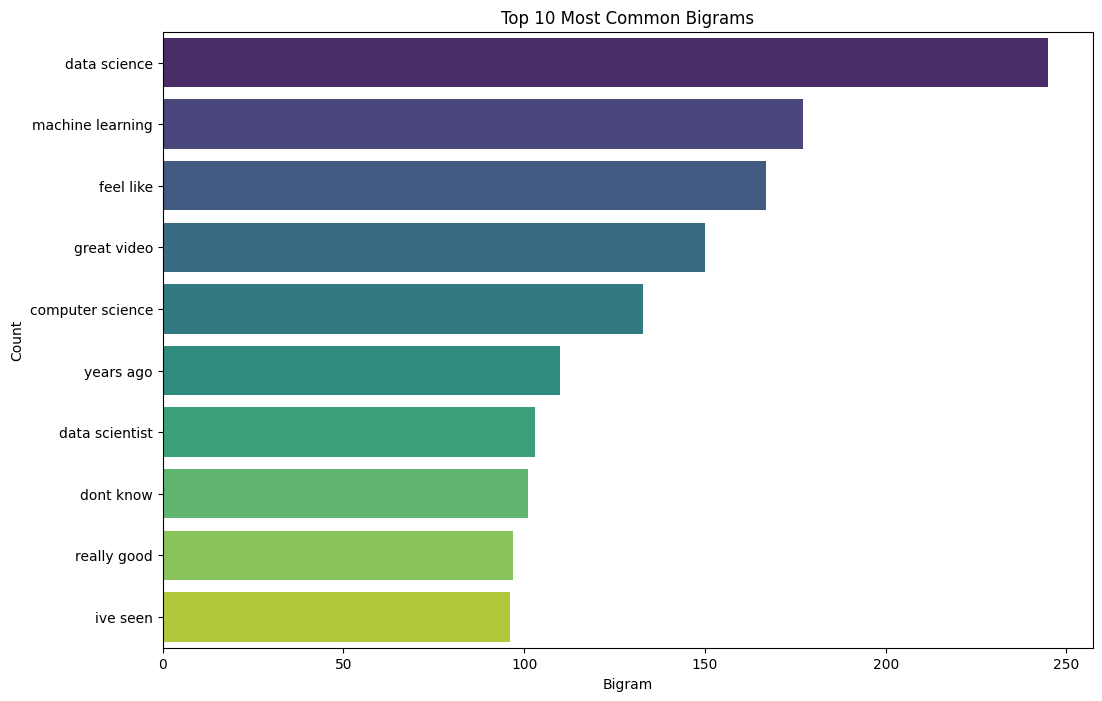

In [40]:
# Top 10 Bigrams
def get_top_ngrams(corpus, n=None):
    
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    
    bag_of_words = vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
  
    return words_freq[:n]


top_10_bigrams = get_top_ngrams(df['Comment'], n=10)

top_10_bigrams_df = pd.DataFrame(top_10_bigrams, columns=['Bigram', 'Count'])


plt.figure(figsize=(12, 8))

sns.barplot(data=top_10_bigrams_df, x='Count', y='Bigram', palette='viridis')

plt.title('Top 10 Most Common Bigrams')

plt.xlabel('Bigram')

plt.ylabel('Count')

plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_23512\983668333.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_trigrams_df, x='Count', y='Trigram', palette='viridis')


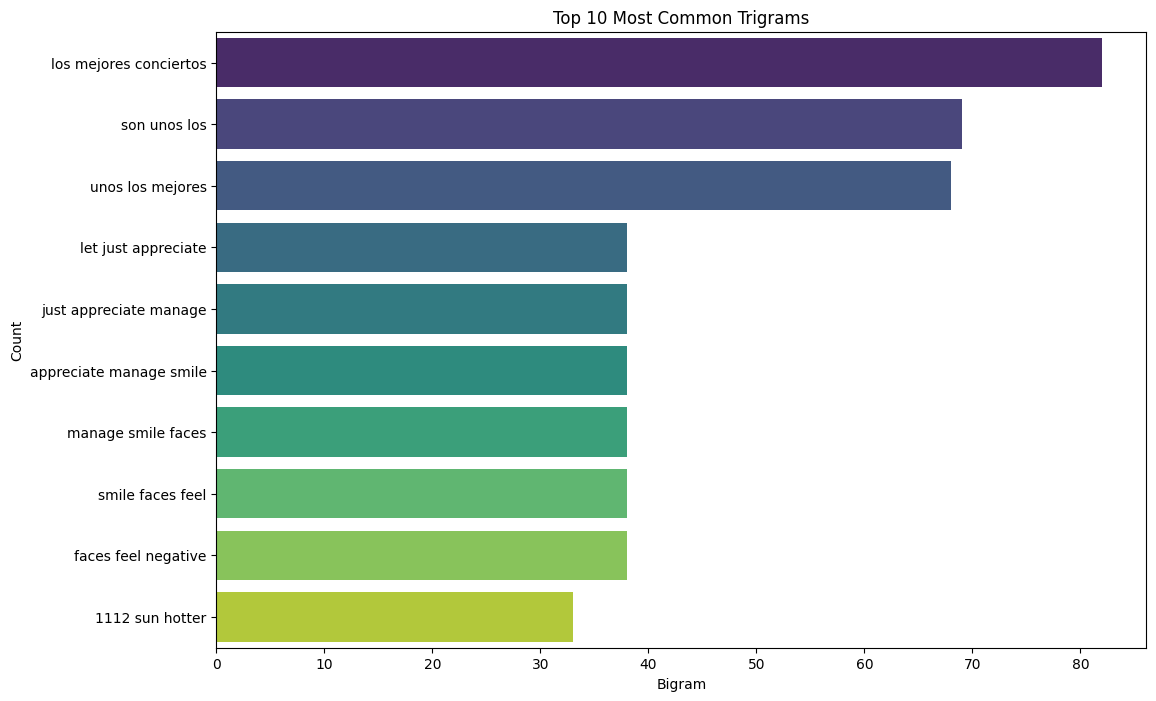

In [41]:
# Top 10 Trigrams
def get_top_ngrams(corpus, n=None):

    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)

    bag_of_words = vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq[:n]


top_10_trigrams = get_top_ngrams(df['Comment'], n=10)

top_10_trigrams_df = pd.DataFrame(top_10_trigrams, columns=['Trigram', 'Count'])


plt.figure(figsize=(12, 8))

sns.barplot(data=top_10_trigrams_df, x='Count', y='Trigram', palette='viridis')

plt.title('Top 10 Most Common Trigrams')

plt.xlabel('Bigram')

plt.ylabel('Count')

plt.show()

In [42]:
# Remove all characters from the ‘Comment’ column except letters, numbers, whitespace, and basic punctuation ( ! ? . , )
df['Comment'] = df['Comment'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s!?.,]', '', str(x)))

In [43]:
all_text = ' '.join(df['Comment'])

char_frequency = Counter(all_text)

char_frequency_df = pd.DataFrame(char_frequency.items(), columns=['Char', 'Count']).sort_values(by='Count', ascending=False)

char_frequency_df

,Char,Count
4,,590996
1,e,301435
2,t,225325
11,a,207323
6,o,200811
14,i,192615
5,n,172531
3,s,168467
8,r,137793
10,h,120846


In [44]:
df.head(5)

,Comment,Sentiment,word_count,num_stopwords,num_char,num_punctuations
0,lets not forget that apple pay in 2014 require...,neutral,57,23,317,0
1,here in nz 50 of retailers dont even have cont...,negative,29,10,163,0
2,i will forever acknowledge this channel with t...,positive,31,16,183,0
3,whenever i go to a place that doesnt take appl...,negative,83,34,450,0
4,apple pay is so convenient secure and easy to ...,positive,26,12,135,0


In [45]:
# Add Stop_words
stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}

df['Comment'] = df['Comment'].apply(
    lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])
)

In [46]:
df.head()

,Comment,Sentiment,word_count,num_stopwords,num_char,num_punctuations
0,lets not forget apple pay 2014 required brand ...,neutral,57,23,317,0
1,nz 50 retailers dont even contactless credit c...,negative,29,10,163,0
2,forever acknowledge channel help lessons ideas...,positive,31,16,183,0
3,whenever go place doesnt take apple pay doesnt...,negative,83,34,450,0
4,apple pay convenient secure easy use used kore...,positive,26,12,135,0


In [47]:
# Using Lemmatize
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

df['Comment'] = df['Comment'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Comment,Sentiment,word_count,num_stopwords,num_char,num_punctuations
0,let not forget apple pay 2014 required brand n...,neutral,57,23,317,0
1,nz 50 retailer dont even contactless credit ca...,negative,29,10,163,0
2,forever acknowledge channel help lesson idea e...,positive,31,16,183,0
3,whenever go place doesnt take apple pay doesnt...,negative,83,34,450,0
4,apple pay convenient secure easy use used kore...,positive,26,12,135,0


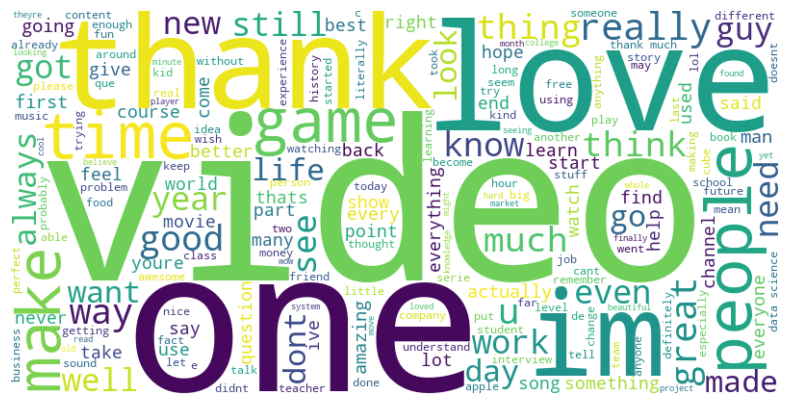

In [48]:
def plot_word_cloud(text):

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))

    plt.figure(figsize=(10, 5))

    plt.imshow(wordcloud, interpolation='bilinear')
    
    plt.axis('off')
    
    plt.show()


plot_word_cloud(df['Comment'])

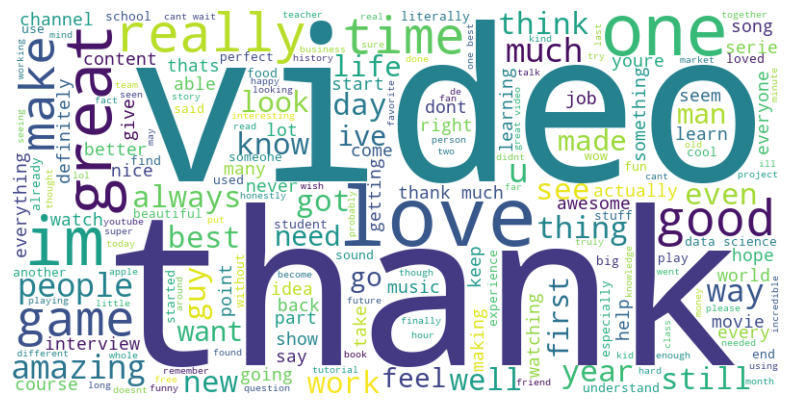

In [49]:
def plot_word_cloud(text):

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    
    plt.figure(figsize=(10, 5))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    
    plt.axis('off')
    
    plt.show()


plot_word_cloud(df[df['Sentiment'] == 'positive']['Comment'])

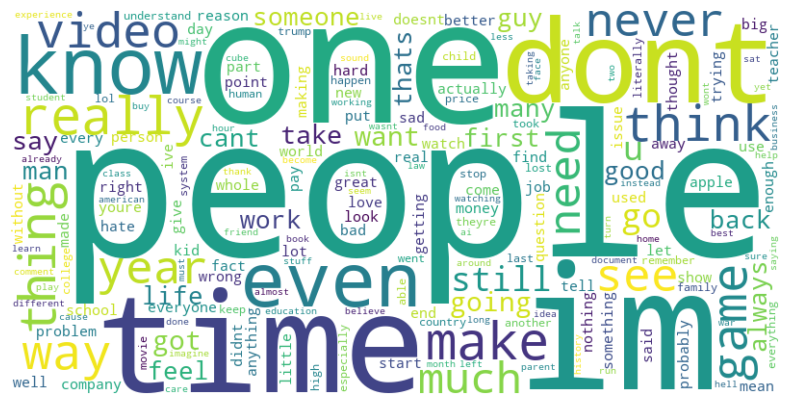

In [50]:
def plot_word_cloud(text):

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    
    plt.figure(figsize=(10, 5))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    
    plt.axis('off')
    
    plt.show()


plot_word_cloud(df[df['Sentiment'] == 'negative']['Comment'])

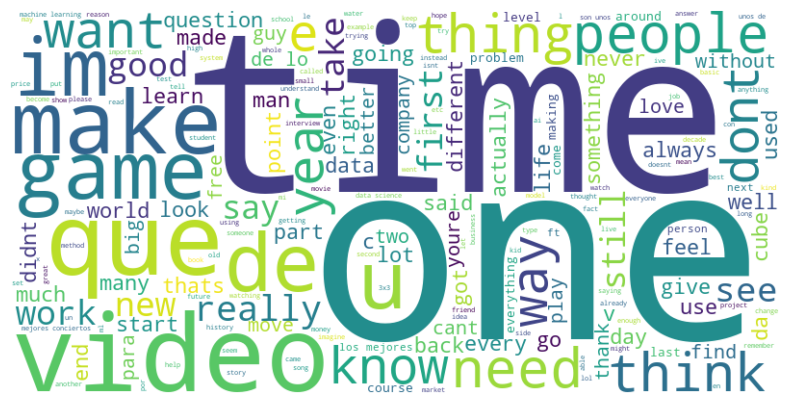

In [51]:
def plot_word_cloud(text):
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))

    plt.figure(figsize=(10, 5))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    
    plt.axis('off')
    
    plt.show()

plot_word_cloud(df[df['Sentiment'] == 'neutral']['Comment'])

C:\Users\Acer\AppData\Local\Temp\ipykernel_23512\3683387108.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words, y=counts, palette='viridis')


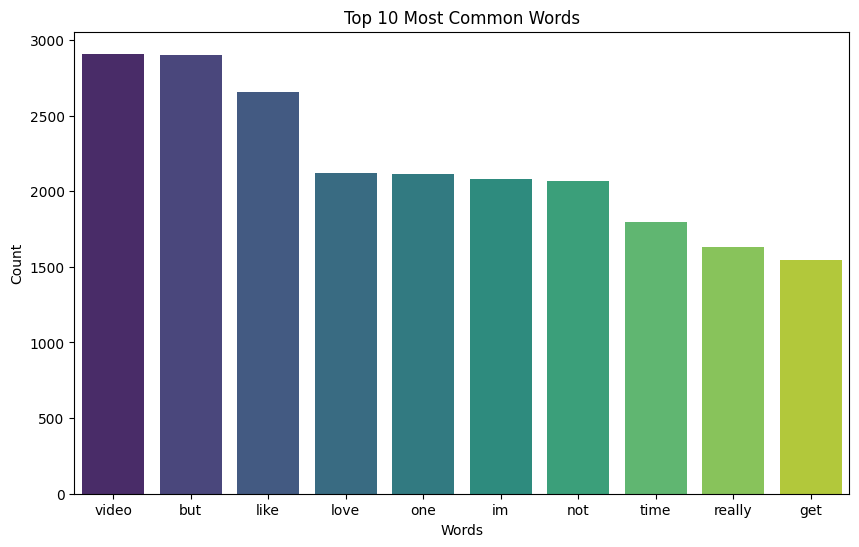

In [52]:
def plot_top_n_word(df, n=20):
    words = ' '.join(df['Comment']).split()

    counter = Counter(words)
    
    most_common_words = counter.most_common(n)

    words, counts = zip(*most_common_words)

    plt.figure(figsize=(10, 6))

    sns.barplot(x=words, y=counts, palette='viridis')

    plt.title(f'Top {n} Most Common Words')
    
    plt.xlabel('Words')
    
    plt.ylabel('Count')

plot_top_n_word(df, n=10)

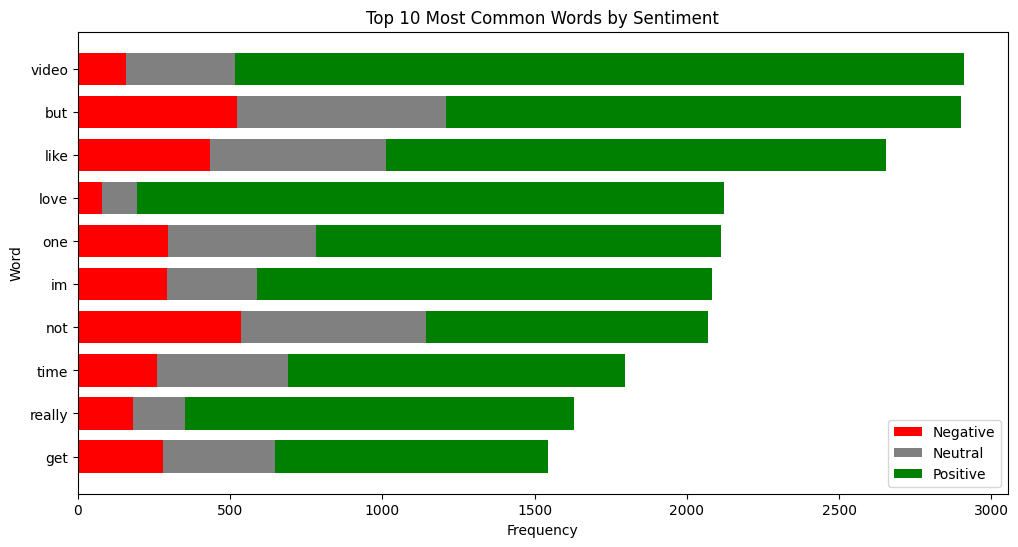

In [55]:
def plot_top_n_word_by_category(df, n=20, start=0):
  word_category_count = {}

  for idx, row in df.iterrows():
    words = row['Comment'].split()
    category = row['Sentiment']
    for word in words:
      if word not in word_category_count:
        word_category_count[word] = {'positive': 0, 'negative': 0, 'neutral': 0}
      word_category_count[word][category] += 1

  
  total_word_counts = {word: sum(counts.values()) for word, counts in word_category_count.items()}

  most_common_words = sorted(total_word_counts.items(), key=lambda x: x[1], reverse=True)[start:start+n]
  
  top_words = [word for word, _ in most_common_words]

  word_labels = top_words
  
  positive_counts = [word_category_count[word]['positive'] for word in top_words]
  
  negative_counts = [word_category_count[word]['negative'] for word in top_words]
  
  neutral_counts = [word_category_count[word]['neutral'] for word in top_words]

  
  plt.figure(figsize=(12, 6))
  bar_width = 0.75

  plt.barh(word_labels, negative_counts, height=bar_width, label='Negative', color='red')
  plt.barh(word_labels, neutral_counts, left=negative_counts ,height=bar_width, label='Neutral', color='grey')
  plt.barh(word_labels, positive_counts, left=[i+j for i,j in zip(negative_counts, neutral_counts)], height=bar_width, label='Positive', color='green')

  plt.xlabel('Frequency')
  plt.ylabel('Word')
  plt.title(f'Top {n} Most Common Words by Sentiment')
  plt.gca().invert_yaxis()
  plt.legend()
  plt.show()

plot_top_n_word_by_category(df, n=10)

# Baseline Model

In [56]:
# Vectorize comment using bag of words
vectorizer = CountVectorizer(max_features=1000) # Bag of Words model with limit of 1000 features

In [57]:
x = vectorizer.fit_transform(df['Comment']).toarray()
y = df['Sentiment']

In [58]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [59]:
x.shape

(17874, 1000)

In [60]:
y

0         neutral
1        negative
2        positive
3        negative
4        positive
           ...   
18403    positive
18404    positive
18405     neutral
18406    positive
18407    positive
Name: Sentiment, Length: 17874, dtype: object

In [62]:
# Set tracking with mlflow
mlflow.set_tracking_uri("file:///D:PROYEK/MACHINE LEARNING/Ansen_yt/Analysis-Sentiment-Youtube-Comment/mlflow_logs_runs")

In [63]:
# Set Experiment
mlflow.set_experiment("1: RF Baseline")

2025/07/03 14:00:41 INFO mlflow.tracking.fluent: Experiment with name '1: RF Baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///D:PROYEK/MACHINE '
 'LEARNING/Ansen_yt/Analysis-Sentiment-Youtube-Comment/mlflow_logs_runs/435525415027126380'), creation_time=1751526041548, experiment_id='435525415027126380', last_update_time=1751526041548, lifecycle_stage='active', name='1: RF Baseline', tags={}>

2025/07/03 14:12:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:12:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.6282517482517482


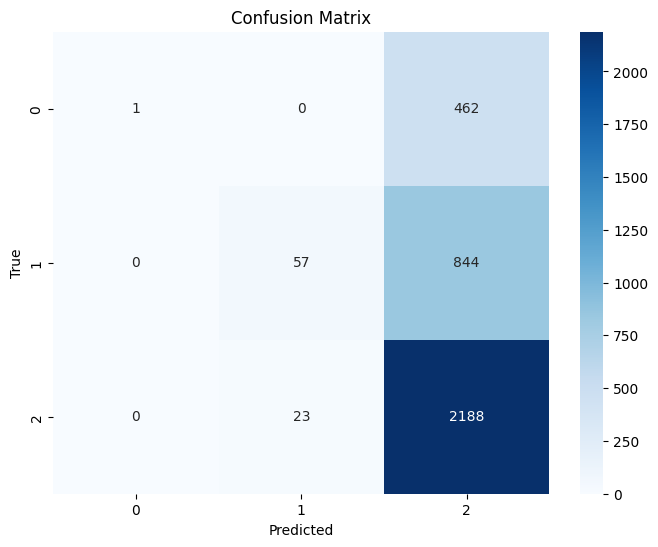

In [64]:
# Train test Split Dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=17, stratify=y)

with mlflow.start_run() as run:
  mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_traintestsplit")
  mlflow.set_tag("Experiment_type", "baseline")
  mlflow.set_tag("model_type", "RandomForestClassifier")
  
    
  mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using bag of words for youtube")

  
  mlflow.log_param("vectorizer_type", "CountVectorizer")
  mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

  # model parameter 
  n_estimators = 200
  max_depth = 15

  
  mlflow.log_param("n_estimators", n_estimators)
  mlflow.log_param("max_depth", max_depth)

  # Train Model
  model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=17)
  model.fit(X_train, y_train)

  # Predict Model
  y_pred = model.predict(X_test)

  # Evaluation Model
  accuracy = accuracy_score(y_test, y_pred)
  mlflow.log_metric("accuracy", accuracy)

  classification_rep = classification_report(y_test, y_pred, output_dict=True)

  for label, metrics in classification_rep.items():
    if isinstance(metrics, dict):
      for metric, value in metrics.items():
        mlflow.log_metric(f"{label}_{metric}", value)

  
  
  cm = confusion_matrix(y_test, y_pred)
  
  plt.figure(figsize=(8, 6))
  
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  
  plt.xlabel('Predicted')
  
  plt.ylabel('True')
  
  plt.title('Confusion Matrix')
  
  plt.savefig("confusion_matrix.png")
  
  mlflow.log_artifact("confusion_matrix.png")

  mlflow.sklearn.log_model(model, "random_forest_model")

  
  df.to_csv('dataset.csv', index=False)
  mlflow.log_artifact('dataset.csv')

print(f"Accuracy: {accuracy}")

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       1.00      0.00      0.00       463
     neutral       0.71      0.06      0.12       901
    positive       0.63      0.99      0.77      2211

    accuracy                           0.63      3575
   macro avg       0.78      0.35      0.30      3575
weighted avg       0.70      0.63      0.50      3575



In [68]:
# Save dataset to csv
df.to_csv('data_preprocess.csv', index=False, quoting=csv.QUOTE_ALL)

In [69]:
df = pd.read_csv('data_preprocess.csv')

## Experiment: Comparision CountVectorizer VS TFIDF

In [75]:
mlflow.set_experiment("2: TFIDF vs BoW")

Traceback (most recent call last):
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 356, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 454, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1595, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1588, 

<Experiment: artifact_location=('file:///D:PROYEK/MACHINE '
 'LEARNING/Ansen_yt/Analysis-Sentiment-Youtube-Comment/mlflow_logs_runs/694152499739379103'), creation_time=1751526867748, experiment_id='694152499739379103', last_update_time=1751526867748, lifecycle_stage='active', name='2: TFIDF vs BoW', tags={}>

In [76]:
df = pd.read_csv('data_preprocess.csv').dropna(subset=['Comment'])
df.shape

(17680, 6)

In [77]:
def run_experiment(vectorizer_type, ngram_range, vectorizer_max_features, vectorizer_name):
  if vectorizer_type == 'BoW':
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)
  else:
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)


  X_train, X_test, y_train, y_test = train_test_split(df['Comment'], df['Sentiment'], test_size=0.2, random_state=17, stratify=df['Sentiment'])

  
  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)

  
  with mlflow.start_run() as run:
    mlflow.set_tag("mlflow.runName", f"{vectorizer_name}_{ngram_range}")
    mlflow.set_tag("Experiment_type", "feature engineering")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    mlflow.set_tag("description", f"RandomForest wiyh {vectorizer_name}, ngram_range={ngram_range}, max_features={vectorizer_max_features}")

    mlflow.log_param("vectorizer_type", vectorizer_type)
    mlflow.log_param("ngram_range", ngram_range)
    mlflow.log_param("vectorizer_max_features", vectorizer_max_features)

    # Model Parameter
    n_estimators = 200
    max_depth = 15

    
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)


    # Train Model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=17)
    model.fit(X_train, y_train)


    # Predict Model
    y_pred = model.predict(X_test)


    # Evaluation Model
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    for label, metrics in classification_rep.items():
      if isinstance(metrics, dict):
        for metric, value in metrics.items():
          mlflow.log_metric(f"{label}_{metric}", value)

    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {vectorizer_name}, {ngram_range}')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    mlflow.sklearn.log_model(model, f"Random_Forest_model_{vectorizer_name}_{ngram_range}")

# Ngram range
ngram_ranges = [(1,1), (1,2), (1,3)]
max_features = 5000

for ngram_range in ngram_ranges:
  run_experiment('BoW', ngram_range, max_features, 'BoW')
  run_experiment('TFIDF', ngram_range, max_features, 'TFIDF')

2025/07/03 14:17:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:17:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

In [78]:
# We use BoW with Trigrams
mlflow.set_experiment("3: BoW Trigrams MaxFeatures")

Traceback (most recent call last):
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 356, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 454, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1595, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1588, 

<Experiment: artifact_location=('file:///D:PROYEK/MACHINE '
 'LEARNING/Ansen_yt/Analysis-Sentiment-Youtube-Comment/mlflow_logs_runs/950744130236051206'), creation_time=1751527567671, experiment_id='950744130236051206', last_update_time=1751527567671, lifecycle_stage='active', name='3: BoW Trigrams MaxFeatures', tags={}>

In [79]:
def run_experiment_bow_bigrams_max_features(max_features):
    ngram_range = (1,3) 

    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    
    X_train, X_test, y_train, y_test = train_test_split(df['Comment'], df['Sentiment'], test_size=0.2, random_state=17, stratify=df['Sentiment'])
    
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    with mlflow.start_run() as run:
        mlflow.set_tag("mlflow.runName", f"BoW_Bigrams_max_features_{max_features}")
        mlflow.set_tag("Experiment_type", "feature engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")
    
        mlflow.set_tag("description", f"RandomForest with BoW Bigrams, max_features={max_features}")
    
        mlflow.log_param("vectorizer_type", "BoW")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)
    
        n_estimators = 200
        max_depth = 15
    
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
    
        
        # Train Model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=17)
        model.fit(X_train, y_train)
    
        
        # Predict Model
        y_pred = model.predict(X_test)
    
        
        # Evaluation Model
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)
    
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
          if isinstance(metrics, dict):
            for metric, value in metrics.items():
              mlflow.log_metric(f"{label}_{metric}", value)
    
        
        
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix: BoW Bigrams, max_features={max_features}')
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()
    
        mlflow.sklearn.log_model(model, f"Random_Forest_model_BoW_Bigrams_{max_features}")

# Max Featue Range
max_feature_values = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

for max_features in max_feature_values:
  run_experiment_bow_bigrams_max_features(max_features)

2025/07/03 14:28:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:28:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/03 14:28:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:28:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/03 14:28:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:28:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_cl

In [81]:
mlflow.set_experiment("4: Handling Imbalanced Data")

Traceback (most recent call last):
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 356, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 454, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1595, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1588, 

<Experiment: artifact_location=('file:///D:PROYEK/MACHINE '
 'LEARNING/Ansen_yt/Analysis-Sentiment-Youtube-Comment/mlflow_logs_runs/434143501632132722'), creation_time=1751528041479, experiment_id='434143501632132722', last_update_time=1751528041479, lifecycle_stage='active', name='4: Handling Imbalanced Data', tags={}>

In [82]:
def run_imbalanced_experiment(imbalanced_methods):
    ngram_range = (1,3)
    max_features = 1000

    Vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
    
    X_train, X_test, y_train, y_test = train_test_split(df['Comment'], df['Sentiment'], test_size=0.2, random_state=17, stratify=df['Sentiment'])
    
    X_train_bow = vectorizer.fit_transform(X_train)
    X_test_bow = vectorizer.transform(X_test)

    
    if imbalanced_methods == 'class_weight':
        class_weight = 'balanced'
    else:
        class_weight = None

        if imbalanced_methods == 'oversampling':
            smote = SMOTE(random_state=17)
            X_train_bow, y_train = smote.fit_resample(X_train_bow, y_train)
        elif imbalanced_methods == 'adasyn':
            adasyn = ADASYN(random_state=17)
            X_train_bow, y_train = adasyn.fit_resample(X_train_bow, y_train)
        elif imbalanced_methods == 'undersampling':
            rus = RandomUnderSampler(random_state=17)
            X_train_bow, y_train = rus.fit_resample(X_train_bow, y_train)
        elif imbalanced_methods == 'smote_enn':
            smoteenn = SMOTEENN(random_state=17)
            X_train_bow, y_train = smoteenn.fit_resample(X_train_bow, y_train)
        elif imbalanced_methods == 'smote_tomek':
            smotetomek = SMOTETomek(random_state=17)
            X_train_bow, y_train = smotetomek.fit_resample(X_train_bow, y_train)

    
    with mlflow.start_run() as run:
        mlflow.set_tag("mlflow.runName", f"imbalance_{imbalanced_methods}_RandomForest_BoW_Bigrams")
        mlflow.set_tag("Experiment_type", "imbalanced Handling")
        mlflow.set_tag("model_type", "RandomForestClassifier")
    
        mlflow.set_tag("description", f"RandomForest with BoW Bigrams, imbalanced handing method = {imbalanced_methods}")
    
        mlflow.log_param("vectorizer_type", "BoW")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", max_features)
    
        n_estimators = 200
        max_depth = 15
    
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("imbalance_method", imbalanced_methods)
    
        
        # Train Model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=17)
        model.fit(X_train_bow, y_train)
    
        
        # Predict Model
        y_pred = model.predict(X_test_bow)
    
        
        # Evaluation Model
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)
    
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
          if isinstance(metrics, dict):
            for metric, value in metrics.items():
              mlflow.log_metric(f"{label}_{metric}", value)
    
        
        
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix: BoW Bigrams, imbalanced method={imbalanced_methods}')
        confusion_matrix_filename = f"confusion_matrix_{imbalanced_methods}.png"
        plt.savefig(confusion_matrix_filename)
        mlflow.log_artifact(confusion_matrix_filename)
        plt.close()
    
        mlflow.sklearn.log_model(model, f"Random_Forest_model_BoW_Bigrams_imbalanced_method_{imbalanced_methods}")

imbalanced_methods = ['class_weight', 'oversampling', 'adasyn', 'undersampling', 'smote_enn', 'smote_tomek']

for method in imbalanced_methods:
    run_imbalanced_experiment(method)

2025/07/03 14:35:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:35:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/03 14:35:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:35:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/03 14:35:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:35:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/03 14:35:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use 

In [83]:
import mlflow
mlflow.set_experiment('5: Algorithm ML')

Traceback (most recent call last):
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 356, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 454, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1595, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1588, 

<Experiment: artifact_location=('file:///D:PROYEK/MACHINE '
 'LEARNING/Ansen_yt/Analysis-Sentiment-Youtube-Comment/mlflow_logs_runs/580500323637852300'), creation_time=1751528427080, experiment_id='580500323637852300', last_update_time=1751528427080, lifecycle_stage='active', name='5: Algorithm ML', tags={}>

In [84]:
# BoW
# Trigrams
# mf = 1000
# Smote Tomek method

In [86]:
# Mapping label
df['Sentiment'] = df['Sentiment'].map({'negative': 2, 'neutral': 0, 'positive': 1})

# BoW vectorizer
ngram_range = (1, 3)
max_features = 1000
vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['Comment'], df['Sentiment'], test_size=0.2, random_state=17, stratify=df['Sentiment'])

# Vectorization
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Handling Imbalanced
smtk = SMOTETomek(random_state=17)
X_train_bow, y_train = smtk.fit_resample(X_train_bow, y_train)

# Daftar model yang akan diuji
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "NaiveBayes": MultinomialNB(),
    "RandomForest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier()
}



# Fungsi untuk evaluasi & logging
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    with mlflow.start_run(run_name=f"{name}_run"):
        mlflow.set_tag("model", name)
        mlflow.log_param("algo_name", name)
        mlflow.log_param("vectorizer", "BoW")
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("sampling", "RandomUnderSampler")

        if isinstance(model, LGBMClassifier):
            X_train = X_train.astype('float32')
            X_test = X_test.astype('float32')

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", acc)

        report = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in report.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        mlflow.sklearn.log_model(model, name + "_model")

        print(f"{name} - Accuracy: {acc:.4f}")



# Jalankan evaluasi semua model
for name, model in models.items():
    evaluate_model(name, model, X_train_bow, X_test_bow, y_train, y_test)

2025/07/03 14:45:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:45:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LogisticRegression - Accuracy: 0.6787


2025/07/03 14:46:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:46:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVM - Accuracy: 0.6753


2025/07/03 14:46:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:46:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


NaiveBayes - Accuracy: 0.6595


2025/07/03 14:47:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:47:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest - Accuracy: 0.6686


2025/07/03 14:47:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:47:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


KNN - Accuracy: 0.4002


2025/07/03 14:47:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:47:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost - Accuracy: 0.7245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3926
[LightGBM] [Info] Number of data points in the train set: 26430, number of used features: 998
[LightGBM] [Info] Start training from score -1.099066
[LightGBM] [Info] Start training from score -1.098726
[LightGBM] [Info] Start training from score -1.098045


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/07/03 14:47:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 14:47:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM - Accuracy: 0.6875


In [127]:
mlflow.set_experiment('6: Hyperparameter Tuning XGBoost - Smote Tomek')

Traceback (most recent call last):
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 356, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 454, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1595, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1588, 

<Experiment: artifact_location=('file:///D:PROYEK/MACHINE '
 'LEARNING/Ansen_yt/Analysis-Sentiment-Youtube-Comment/mlflow_logs_runs/482046557833625484'), creation_time=1751529292803, experiment_id='482046557833625484', last_update_time=1751529292803, lifecycle_stage='active', name='6: Hyperparameter Tuning XGBoost', tags={}>

In [128]:
ngram_range = (1, 3)
max_features = 1000
vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

X = vectorizer.fit_transform(df['Comment'])
y = df['Sentiment']

# Handling Imbalanced
smtk = SMOTETomek(random_state=17)
X_resampled, y_resampled = smtk.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=17, stratify=y_resampled)

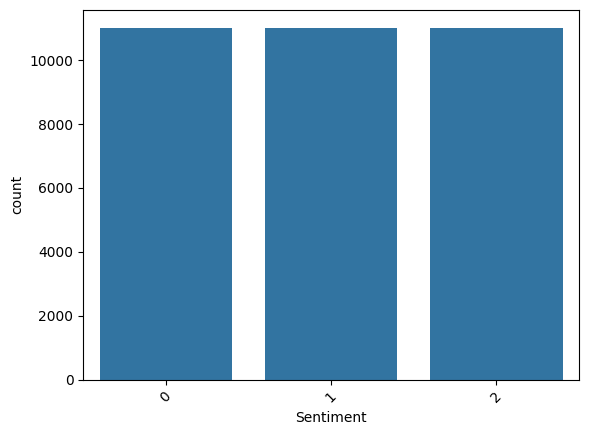

In [129]:
sns.countplot(x=y_resampled, data=df)
plt.xticks(rotation=45)
plt.show()

In [99]:
df.head()

,Comment,Sentiment,word_count,num_stopwords,num_char,num_punctuations
0,let not forget apple pay 2014 required brand n...,0,57,23,317,0
1,nz 50 retailer dont even contactless credit ca...,2,29,10,163,0
2,forever acknowledge channel help lesson idea e...,1,31,16,183,0
3,whenever go place doesnt take apple pay doesnt...,2,83,34,450,0
4,apple pay convenient secure easy use used kore...,1,26,12,135,0


In [ ]:
# XGBOOST HYPERPARAMETER SMOTE TOMEK

def log_mlflow(model_name, model, X_train, X_test, y_train, y_test, params, trial_number):
    with mlflow.start_run():
        mlflow.set_tag("mlflow.runName", f"V2_Trial_{trial_number}_{model_name}_RUS_BoW_Bigrams")
        mlflow.set_tag("experiment_type", "algorithm_comparison")
        mlflow.log_param("algo_name", model_name)
        
        for key, value in params.items():
            mlflow.log_param(key, value)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)
        
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)
                    
        mlflow.xgboost.log_model(model, f"{model_name}_model")
        
        return accuracy

def objective_xgboost(trial):
    # XGBoost hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_float('gamma', 1e-4, 1.0, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.5, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True)
    
    params = {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'colsample_bylevel': colsample_bylevel,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda
    }
    
    model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=17,
        eval_metric='logloss',  # XGBoost specific
        use_label_encoder=False  # To avoid warning
    )
    
    accuracy = log_mlflow("XGBoost", model, X_train, X_test, y_train, y_test, params, trial.number)
    return accuracy

def run_optuna_experiment():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_xgboost, n_trials=100)
    
    best_params = study.best_params
    print("Best parameters found:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    print(f"Best accuracy: {study.best_value:.4f}")
    
    best_model = XGBClassifier(
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        colsample_bylevel=best_params['colsample_bylevel'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        random_state=17,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Log the best model with MLflow
    final_accuracy = log_mlflow("XGBoost_Best", best_model, X_train, X_test, y_train, y_test, best_params, "Best")
    print(f"Final model accuracy: {final_accuracy:.4f}")
    
    # Plot parameter importance
    try:
        optuna.visualization.plot_param_importances(study).show()
    except Exception as e:
        print(f"Could not plot parameter importances: {e}")
    
    # Plot optimization history
    try:
        optuna.visualization.plot_optimization_history(study).show()
    except Exception as e:
        print(f"Could not plot optimization history: {e}")
    
    return best_model, best_params, study

# Run the experiment
run_optuna_experiment()

In [131]:
mlflow.set_experiment('6.1: Hyperparameter XGBoost - Adasyn')

Traceback (most recent call last):
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 356, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 454, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1595, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1588, 

<Experiment: artifact_location=('file:///D:PROYEK/MACHINE '
 'LEARNING/Ansen_yt/Analysis-Sentiment-Youtube-Comment/mlflow_logs_runs/204948799003859042'), creation_time=1751531453558, experiment_id='204948799003859042', last_update_time=1751531453558, lifecycle_stage='active', name='6.1: Hyperparameter XGBoost - Adasyn', tags={}>

In [132]:
ngram_range = (1, 3)
max_features = 1000
vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

X = vectorizer.fit_transform(df['Comment'])
y = df['Sentiment']

# Handling Imbalanced
adsyn = ADASYN(random_state=17)
X_resampled, y_resampled = adsyn.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=17, stratify=y_resampled)

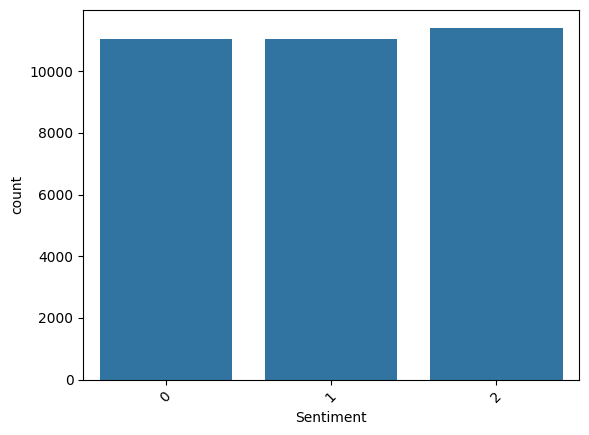

In [133]:
sns.countplot(x=y_resampled, data=df)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# XGBOOST HYPERPARAMETER ADASYN

def log_mlflow(model_name, model, X_train, X_test, y_train, y_test, params, trial_number):
    with mlflow.start_run():
        mlflow.set_tag("mlflow.runName", f"V2_Trial_{trial_number}_{model_name}_RUS_BoW_Bigrams")
        mlflow.set_tag("experiment_type", "algorithm_comparison")
        mlflow.log_param("algo_name", model_name)
        
        for key, value in params.items():
            mlflow.log_param(key, value)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)
        
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)
                    
        mlflow.xgboost.log_model(model, f"{model_name}_model")
        
        return accuracy

def objective_xgboost(trial):
    # XGBoost hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_float('gamma', 1e-4, 1.0, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.5, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True)
    
    params = {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'colsample_bylevel': colsample_bylevel,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda
    }
    
    model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=17,
        eval_metric='logloss',  # XGBoost specific
        use_label_encoder=False  # To avoid warning
    )
    
    accuracy = log_mlflow("XGBoost", model, X_train, X_test, y_train, y_test, params, trial.number)
    return accuracy

def run_optuna_experiment():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_xgboost, n_trials=100)
    
    best_params = study.best_params
    print("Best parameters found:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    print(f"Best accuracy: {study.best_value:.4f}")
    
    best_model = XGBClassifier(
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        colsample_bylevel=best_params['colsample_bylevel'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        random_state=17,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Log the best model with MLflow
    final_accuracy = log_mlflow("XGBoost_Best", best_model, X_train, X_test, y_train, y_test, best_params, "Best")
    print(f"Final model accuracy: {final_accuracy:.4f}")
    
    # Plot parameter importance
    try:
        optuna.visualization.plot_param_importances(study).show()
    except Exception as e:
        print(f"Could not plot parameter importances: {e}")
    
    # Plot optimization history
    try:
        optuna.visualization.plot_optimization_history(study).show()
    except Exception as e:
        print(f"Could not plot optimization history: {e}")
    
    return best_model, best_params, study

# Run the experiment
run_optuna_experiment()

In [107]:
mlflow.set_experiment('6.2: Hyperparameter XGBoost - Oversampling')

Traceback (most recent call last):
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 356, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 454, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1595, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1588, 

<Experiment: artifact_location=('file:///D:PROYEK/MACHINE '
 'LEARNING/Ansen_yt/Analysis-Sentiment-Youtube-Comment/mlflow_logs_runs/271010785328416849'), creation_time=1751532780541, experiment_id='271010785328416849', last_update_time=1751532780541, lifecycle_stage='active', name='6.2: Hyperparameter XGBoost - Oversampling', tags={}>

In [110]:
df.shape

(17680, 6)

In [119]:
ngram_range = (1, 3)
max_features = 1000
vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)

X = vectorizer.fit_transform(df['Comment'])
y = df['Sentiment']

# Step 4: Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=17)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=17, stratify=y_resampled)

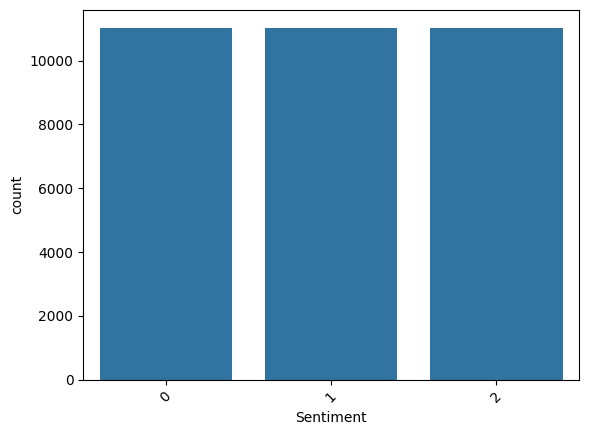

In [121]:
sns.countplot(x=y_resampled, data=df)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# XGBOOST HYPERPARAMETER Oversampling

def log_mlflow(model_name, model, X_train, X_test, y_train, y_test, params, trial_number):
    with mlflow.start_run():
        mlflow.set_tag("mlflow.runName", f"Trial_{trial_number}_{model_name}_RUS_BoW_Bigrams")
        mlflow.set_tag("experiment_type", "algorithm_comparison")
        mlflow.log_param("algo_name", model_name)
        
        for key, value in params.items():
            mlflow.log_param(key, value)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)
        
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)
                    
        mlflow.xgboost.log_model(model, f"{model_name}_model")
        
        return accuracy

def objective_xgboost(trial):
    # XGBoost hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_float('gamma', 1e-4, 1.0, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.5, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True)
    
    params = {
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'colsample_bylevel': colsample_bylevel,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda
    }
    
    model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=17,
        eval_metric='logloss',  # XGBoost specific
        use_label_encoder=False  # To avoid warning
    )
    
    accuracy = log_mlflow("XGBoost", model, X_train, X_test, y_train, y_test, params, trial.number)
    return accuracy

def run_optuna_experiment():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_xgboost, n_trials=100)
    
    best_params = study.best_params
    print("Best parameters found:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    print(f"Best accuracy: {study.best_value:.4f}")
    
    best_model = XGBClassifier(
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        colsample_bylevel=best_params['colsample_bylevel'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        random_state=17,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Log the best model with MLflow
    final_accuracy = log_mlflow("XGBoost_Best", best_model, X_train, X_test, y_train, y_test, best_params, "Best")
    print(f"Final model accuracy: {final_accuracy:.4f}")
    
    # Plot parameter importance
    try:
        optuna.visualization.plot_param_importances(study).show()
    except Exception as e:
        print(f"Could not plot parameter importances: {e}")
    
    # Plot optimization history
    try:
        optuna.visualization.plot_optimization_history(study).show()
    except Exception as e:
        print(f"Could not plot optimization history: {e}")
    
    return best_model, best_params, study

# Run the experiment
run_optuna_experiment()

# Stacking

In [145]:
from sklearn.ensemble import StackingClassifier
from imblearn.pipeline import Pipeline

In [141]:
df = df.dropna()

In [147]:
X_clean = df['Comment']
y_clean = df['Sentiment']


bow = CountVectorizer(ngram_range=(1,3), max_features=1000)
X_bow = bow.fit_transform(X_clean)


X_train, X_test, y_train, y_test = train_test_split(X_bow, y_clean, test_size=0.2, random_state=17, stratify=y_clean)


num_classes = 3

model1 = Pipeline([
    ('Smotetomek', SMOTETomek(random_state=17)),
    ('Xgb', XGBClassifier(
        objective='multi:softprob',       # Multiclass
        num_class=num_classes,            # Jumlah kelas
        colsample_bylevel=0.8369220066178561,
        colsample_bytree=0.8849946934153168,
        gamma=0.17345885892923446,
        learning_rate=0.08119271310839746,
        max_depth=10,
        min_child_weight=2,
        n_estimators=293,
        reg_alpha=0.02895037724544203,
        reg_lambda=0.00014445876489744866,
        subsample=0.821177377650418,
        use_label_encoder=False,
        eval_metric='mlogloss',           # Multiclass logloss
        random_state=17
    ))
])

model2 = Pipeline([
    ('Adasyn', ADASYN(random_state=17)),
    ('Xgb', XGBClassifier(
        objective='multi:softprob',       # Multiclass
        num_class=num_classes,            # Jumlah kelas
        colsample_bylevel=0.5346422618977088,
        colsample_bytree=0.7218620115633122,
        gamma=0.004899499306749432,
        learning_rate=0.07044186773247989,
        max_depth=10,
        min_child_weight=2,
        n_estimators=274,
        reg_alpha=0.0022803317281842226,
        reg_lambda=0.0001518805773782877,
        subsample=0.8424928574893723,
        use_label_encoder=False,
        eval_metric='mlogloss',           # Multiclass logloss
        random_state=17
    ))
])


meta_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')


stacking_model = StackingClassifier(
    estimators=[
        ('xgb_smtk', model1),
        ('xgb_adsyn', model2)
    ],
    final_estimator=meta_model,
    cv=5
)


stacking_model.fit(X_train_bow, y_train)

y_pred = stacking_model.predict(X_test_bow)


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:01:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:01:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:01:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:01:47] WARNING: C:\actions-r

In [148]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.64      0.59       866
           1       0.82      0.85      0.84      2207
           2       0.62      0.33      0.43       463

    accuracy                           0.73      3536
   macro avg       0.67      0.61      0.62      3536
weighted avg       0.73      0.73      0.72      3536



# Final Model

In [150]:
df = pd.read_csv('data_preprocess.csv')

df = df.dropna(subset=['Comment'])

df['Sentiment'] = df['Sentiment'].map({'negative': 2, 'neutral': 0, 'positive': 1})

ngram_range = (1, 3)
max_features = 1000
num_classes = 3
vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)

X = vectorizer.fit_transform(df['Comment'])
y = df['Sentiment']

# Step 4: Apply SMOTE to handle class imbalance
smtk = SMOTETomek(random_state=17)
X_resampled, y_resampled = smtk.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=17, stratify=y_resampled)

model = XGBClassifier(
    objective='multi:softprob',       # Multiclass
    num_class=num_classes,            # Jumlah kelas
    colsample_bylevel=0.8369220066178561,
    colsample_bytree=0.8849946934153168,
    gamma=0.17345885892923446,
    learning_rate=0.08119271310839746,
    max_depth=10,
    min_child_weight=2,
    n_estimators=293,
    reg_alpha=0.02895037724544203,
    reg_lambda=0.00014445876489744866,
    subsample=0.821177377650418,
    use_label_encoder=False,
    eval_metric='mlogloss',           # Multiclass logloss
    random_state=17
)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:19:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.71      0.81      0.76      2202
           1       0.87      0.82      0.84      2203
           2       0.85      0.79      0.82      2204

    accuracy                           0.80      6609
   macro avg       0.81      0.80      0.80      6609
weighted avg       0.81      0.80      0.80      6609



In [ ]:
import joblib

joblib.dump(model, 'xgb_model.pkl')
joblib.dump(vectorizer, 'bow_vectorizer.pkl')

TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['ellipsis', 'str']

In [21]:
xgb_loaded = joblib.load('../xgb_model.pkl')
vectorizer_loaded = joblib.load('../bow_vectorizer.pkl')

label_mapping = {
    0: 'Neutral',
    1: 'Positive',
    2: 'Negative'
}

# Preprocess new data
new_text = ["nz 50 retailer dont even contactless credit card machine like paywave support apple pay dont like high fee come"]
new_X = vectorizer_loaded.transform(new_text)

# Prediksi
pred_label = xgb_loaded.predict(new_X)[0]  # Ambil label angka
pred_text = label_mapping[pred_label]      # Konversi ke kalimat
print(pred_text)

Neutral
